In [ ]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo y el tokenizador
modelo = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn', output_attentions=True)
tokenizador = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Texto de ejemplo
texto = (
    "La inteligencia artificial (IA) se refiere a la simulación de procesos de inteligencia humana "
    "por parte de máquinas, especialmente sistemas informáticos. Estos procesos incluyen el aprendizaje "
    "(la adquisición de información y reglas para el uso de la información), el razonamiento (uso de reglas "
    "para alcanzar conclusiones aproximadas o definitivas) y la autocorrección. Las aplicaciones particulares "
    "de la IA incluyen sistemas expertos, reconocimiento de voz y visión artificial."
)


In [ ]:
# Tokenizar el texto de entrada
entradas = tokenizador(texto, max_length=1024, return_tensors='pt', truncation=True)

# Generar el resumen
salida = modelo.generate(entradas['input_ids'], num_beams=4, max_length=50, early_stopping=True)

# Extraer el resumen
resumen_ids = salida[0]

# Decodificar el resumen generado
resumen = tokenizador.decode(resumen_ids, skip_special_tokens=True)
print("Resumen:")
print(resumen)

Resumen:
La inteligencia artificial (IA) se refiere a la simulación de procesos de inteligence humana por parte de máquinas. Las aplicaciones particulares de la


In [ ]:
# Obtener atenciones del modelo
# Aquí volvemos a pasar la entrada a través del modelo con output_attentions=True
salida_atencion = modelo(input_ids=entradas['input_ids'], decoder_input_ids=resumen_ids.unsqueeze(0), output_attentions=True, return_dict=True)
atenciones = salida_atencion.cross_attentions

Estructura de las atenciones: [torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162]), torch.Size([1, 16, 50, 162])]


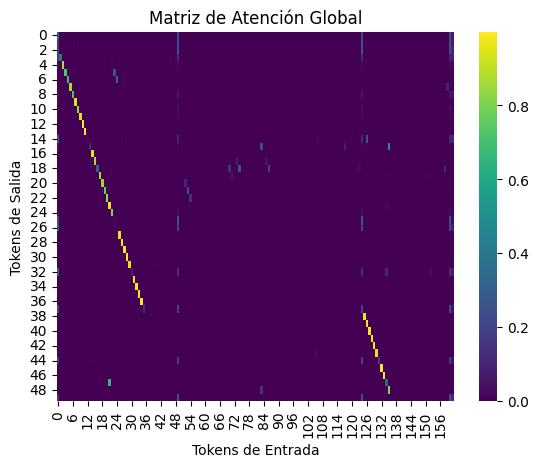

In [ ]:
# Asegurémonos de que estamos accediendo correctamente a las atenciones
# Las atenciones de BART tienen la forma (num_layers, batch_size, num_heads, seq_length_decoder, seq_length_encoder)
print(f"Estructura de las atenciones: {[at.shape for at in atenciones]}")

# Visualizar la atención de la primera capa y la primera cabeza
atencion = atenciones[0][0][0].detach().numpy()

# Graficar la matriz de atención
sns.heatmap(atencion, cmap='viridis')
plt.title('Matriz de Atención Global')
plt.xlabel('Tokens de Entrada')
plt.ylabel('Tokens de Salida')
plt.show()

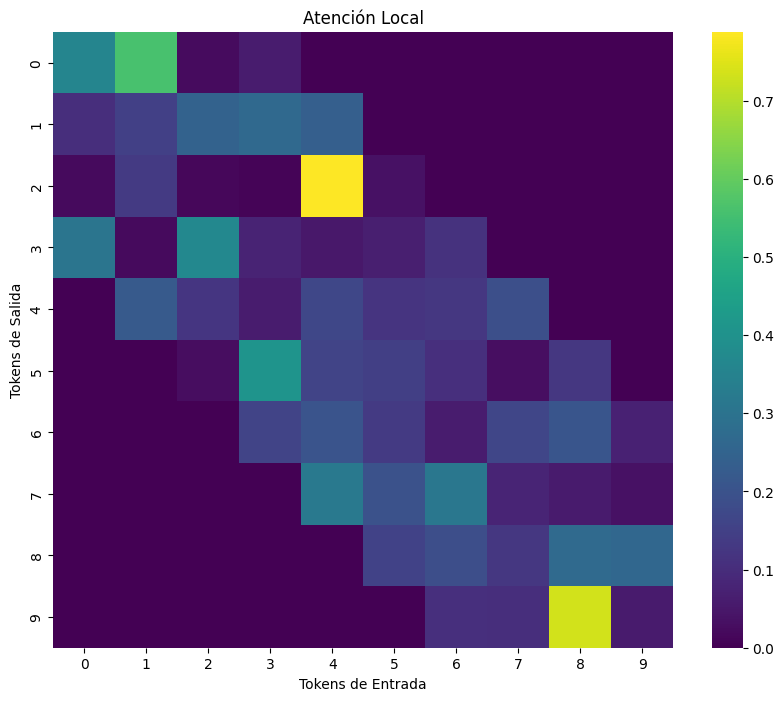

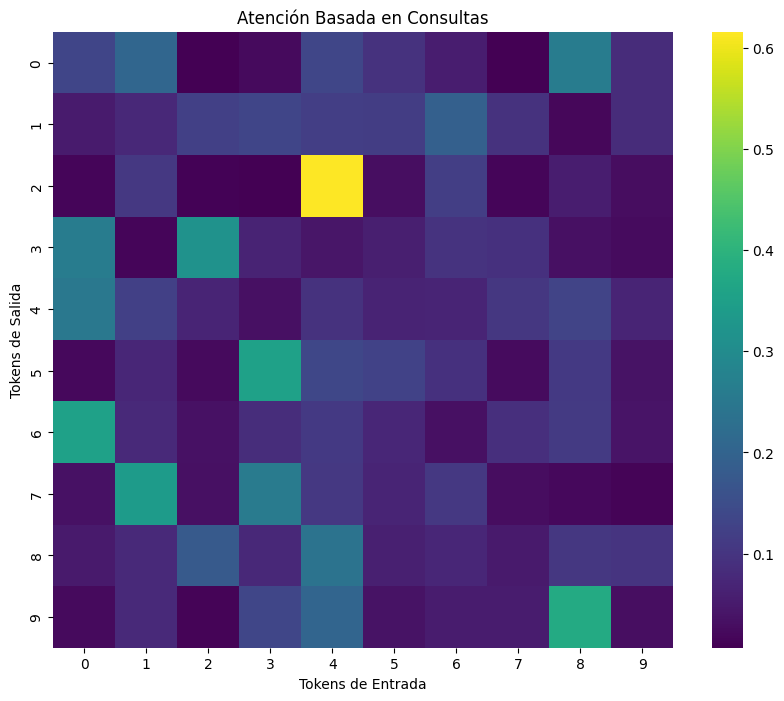

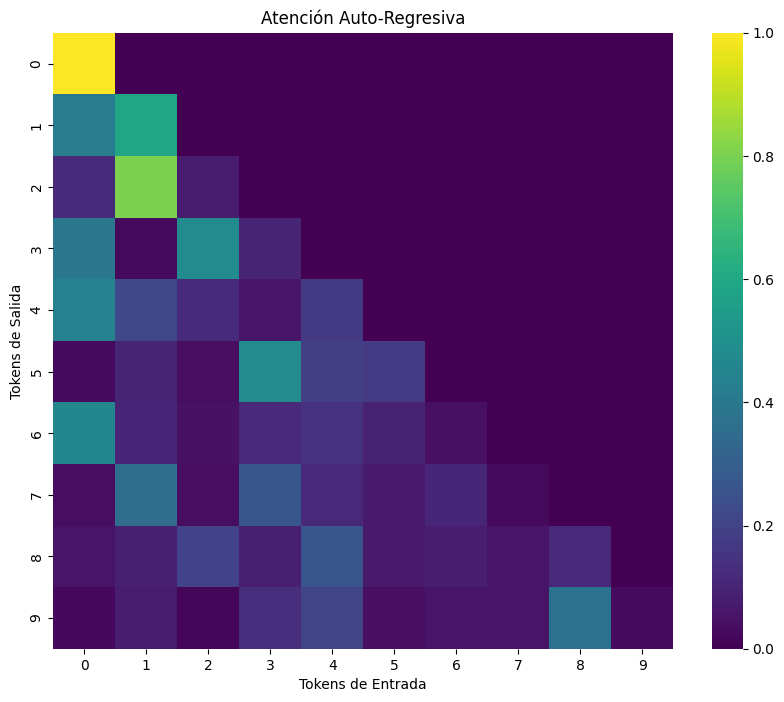

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Función de atención escalar para simplificar
def atencion_escalar(query, key, value, mask=None):
    scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(key.size(-1), dtype=torch.float32))
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    atencion = F.softmax(scores, dim=-1)
    salida = torch.matmul(atencion, value)
    return salida, atencion

# Datos de ejemplo
tokens = 10
dim = 16
query = torch.randn((1, tokens, dim))
key = torch.randn((1, tokens, dim))
value = torch.randn((1, tokens, dim))

# 1. Atención Local (ventana de 3 tokens)
ventana = 3
mask_local = torch.zeros((tokens, tokens))
for i in range(tokens):
    for j in range(max(0, i - ventana), min(tokens, i + ventana + 1)):
        mask_local[i, j] = 1

salida_local, atencion_local = atencion_escalar(query, key, value, mask_local)

# 2. Atención Basada en Consultas (sin máscara, atención completa)
salida_query, atencion_query = atencion_escalar(query, key, value)

# 3. Atención Auto-Regresiva (máscara triangular inferior)
mask_autorregresiva = torch.tril(torch.ones((tokens, tokens)))

salida_autorregresiva, atencion_autorregresiva = atencion_escalar(query, key, value, mask_autorregresiva)

# Visualizar las atenciones
def visualizar_atencion(atencion, titulo):
    plt.figure(figsize=(10, 8))
    sns.heatmap(atencion[0].detach().numpy(), cmap='viridis')
    plt.title(titulo)
    plt.xlabel('Tokens de Entrada')
    plt.ylabel('Tokens de Salida')
    plt.show()

visualizar_atencion(atencion_local, 'Atención Local')
visualizar_atencion(atencion_query, 'Atención Basada en Consultas')
visualizar_atencion(atencion_autorregresiva, 'Atención Auto-Regresiva')